# Loan Dataset Classification

In [1]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup

import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# from sklearn.externals.six import StringIO
# import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from sklearn.linear_model import LogisticRegression


Note: The dataset for this project is retrieved originally from Kaggle: https://www.kaggle.com/burak3ergun/loan-data-set

Retrieving Data from Github and Creating Pandas Dataframe 

In [2]:
wiki_url = "https://github.com/cneves20/Machine-Learning-with-Python/blob/main/loan_data_set.csv" 
response = requests.get(wiki_url)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table', {'class':'js-csv-data csv-data js-file-line-container'}).tbody 

rows = table.find_all('tr')
columns = ['Number','Loan ID','Gender','Married','Dependents','Education','Self Employed','Applicant Income',\
           'Co-applicant Income','Loan Amount','Loan Amount Term','Credit History','Property Area','Loan Status']

df = pd.DataFrame(columns=columns)

# populate dataframe with the table created
for i in range(0, len(rows)):
    tds = rows[i].find_all('td')
    if len(tds) == 13:
        values = [tds[0].text, tds[1].text, tds[2].text, tds[3].text, tds[4].text, tds[5].text,\
                 tds[6].text, tds[7].text, tds[8].text, tds[9].text, tds[10].text, tds[11].text, tds[12].text, tds[13].text]
    else:
        values = [td.text for td in tds]
    #print(values)    
    df = df.append(pd.Series(values, index=columns), ignore_index=True)
    
df = df.sort_values(by ='Loan ID' ) #sort values by Loan ID just to compare when joining data frames
df.reset_index(drop=True, inplace=True) #reset index values
df.head()

,Number,Loan ID,Gender,Married,Dependents,Education,Self Employed,Applicant Income,Co-applicant Income,Loan Amount,Loan Amount Term,Credit History,Property Area,Loan Status
0,,LP001002,Male,No,0,Graduate,No,5849,0,,360,1,Urban,Y
1,,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
2,,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
3,,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
4,,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y


Exploring & Cleaning Dataframe Created

In [3]:
df.describe(include='all') # show summary of all the columnst 

#drop columns that are not critical to predict loan approval
del df['Number'] 
del df['Loan ID']

# Check dataframe for missing values
missing_data = df.isnull()
missing_data.head()
df.replace("", np.nan, inplace = True) # replace missing data NaN
df = df.dropna() # drop missing rows with missing values - only for simplification purposes in this project
df.reset_index(drop=True, inplace=True) #reset index values

df.head()

,Gender,Married,Dependents,Education,Self Employed,Applicant Income,Co-applicant Income,Loan Amount,Loan Amount Term,Credit History,Property Area,Loan Status
0,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
3,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1,Urban,Y


Converting Categorical Features to Numerical Values

In [4]:
#Transfom catergorical data into numerical

#for gender column: male = 0 and female = 1
df['Gender'] = df['Gender'].replace(['Male','Female'],['0','1'])
#for married column: no = 0 and yes = 1
df['Married'] = df['Married'].replace(['No','Yes'],['0','1'])
#for education column: not graduate = 0 and graduate = 1
df['Education'] = df['Education'].replace(['Not Graduate','Graduate'],['0','1'])
#for self employed column: no = 0 and yes = 1
df['Self Employed'] = df['Self Employed'].replace(['No','Yes'],['0','1'])
#for property area: urban = 1, semiurban = 2, rural = 3
df['Property Area'] = df['Property Area'].replace(['Urban','Semiurban','Rural'],['1','2','3'])
#for loan status column: n = 0 and y = 1
df['Loan Status'] = df['Loan Status'].replace(['N','Y'],['0','1'])
#for dependents column: assume 3 as max value of dependents
df['Dependents'] = df['Dependents'].replace(['3+'],['3'])

df.head()

,Gender,Married,Dependents,Education,Self Employed,Applicant Income,Co-applicant Income,Loan Amount,Loan Amount Term,Credit History,Property Area,Loan Status
0,0,1,1,1,0,4583,1508,128,360,1,3,0
1,0,1,0,1,1,3000,0,66,360,1,1,1
2,0,1,0,0,0,2583,2358,120,360,1,1,1
3,0,0,0,1,0,6000,0,141,360,1,1,1
4,0,1,2,1,1,5417,4196,267,360,1,1,1


Normalizing Data 

In [5]:
# Lets define feature sets X and y

df.columns
X = df[['Gender', 'Married', 'Dependents', 'Education', 'Self Employed','Applicant Income', 'Co-applicant Income', 'Loan Amount',\
       'Loan Amount Term', 'Credit History', 'Property Area']].values 
y = df['Loan Status'].values

# Data normalization 
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (384, 11) (384,)
Test set: (96, 11) (96,)


Classification: K nearest neighbor (KNN) 

Train set Accuracy:  0.8229166666666666
Test set Accuracy:  0.7604166666666666


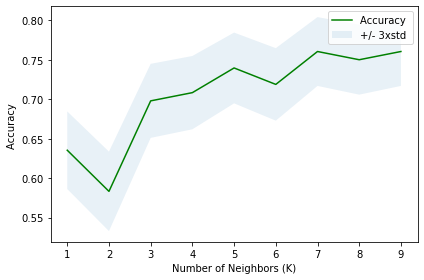

The best accuracy was with 0.7604166666666666 with k= 7
KNN F1-score: 0.73


In [7]:
# Training Lets start the algorithm with K=5 for now:

K = 10
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))
ConfustionMx = [];
for n in range(1,K):

    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    #predicting
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
   
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

# Accuracy evaluation
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

mean_acc

# Plot model accuracy for Different number of Neighbors
plt.plot(range(1,K),mean_acc,'g')
plt.fill_between(range(1,K),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

# Load Test set for evaluation
y = neigh.predict(X_test)
#print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, y))
print("KNN F1-score: %.2f" % f1_score(y_test, y, average='weighted') )
#print("LR LogLoss: %.2f" % log_loss(y_test, y))

Classification: Decision Tree

Decision Trees's Accuracy:  0.7291666666666666
KNN F1-score: 0.73


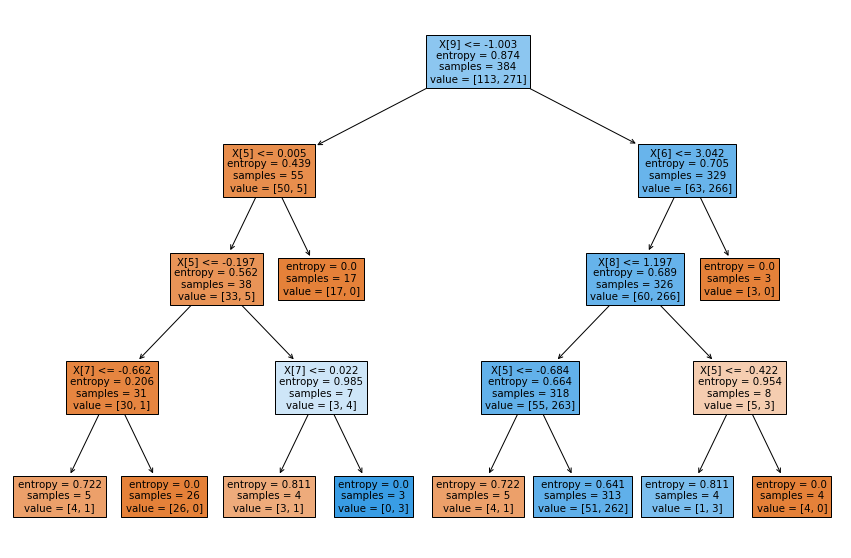

In [8]:
# # Setting up the Decision Tree

#Train Model and Predict  
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model
#predicting
yhat = DT_model.predict(X_test)

# Accuracy evaluation
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, yhat))

# Plot model accuracy for Different number of Neighbors
plt.figure(figsize=(15,10))
tree.plot_tree(DT_model, filled =True)

# Load Test set for evaluation
y = neigh.predict(X_test)
#print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, y))
print("KNN F1-score: %.2f" % f1_score(y_test, y, average='weighted') )
# # #print("LR LogLoss: %.2f" % log_loss(y_test, y))


Classification: Super Vector Machine

SVM F1-score: 0.72
              precision    recall  f1-score   support

           0       0.82      0.40      0.54        35
           1       0.73      0.95      0.83        61

    accuracy                           0.75        96
   macro avg       0.78      0.68      0.68        96
weighted avg       0.77      0.75      0.72        96

Confusion matrix, without normalization
[[58  3]
 [21 14]]


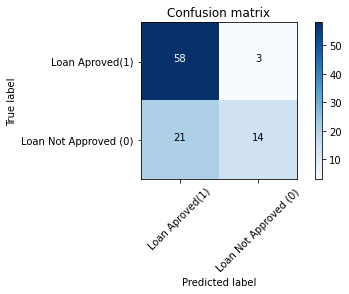

In [9]:
#Train Model and Predict  

SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_train, y_train) 
yhat = SVM_model.predict(X_test)
yhat

# Accuracy evaluation
print("SVM F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )


# Plot model a
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['1','0'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Loan Aproved(1)','Loan Not Approved (0)'],normalize= False,  title='Confusion matrix')

Classification: Logistic Regression

LR F1-score: 0.72
              precision    recall  f1-score   support

           0       0.87      0.37      0.52        35
           1       0.73      0.97      0.83        61

    accuracy                           0.75        96
   macro avg       0.80      0.67      0.68        96
weighted avg       0.78      0.75      0.72        96

Confusion matrix, without normalization
[[59  2]
 [22 13]]


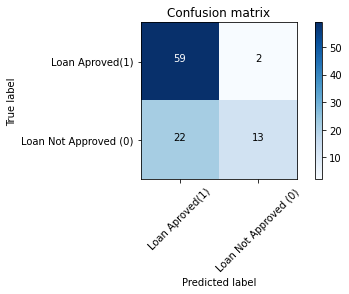

In [10]:
#modelling 
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model
yhat = LR_model.predict(X_test)
yhat_prob = LR_model.predict_proba(X_test)
yhat

# Accuracy evaluation
print("LR F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )
# print("LR LogLoss: %.2f" % log_loss(test_y, yhat_prob)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['1','0'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Loan Aproved(1)','Loan Not Approved (0)'],normalize= False,  title='Confusion matrix')
